In [54]:

from sklearn.datasets import load_wine
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.spatial import ConvexHull, Delaunay
import pickle
import os
import time





In [55]:
def calculate_concave_hull(coordinates, length_threshold=50):
    """
    Calculate the concave hull of the given coordinates.

    Parameters:
    coordinates (np.ndarray): Array of shape (n_samples, n_features) containing the coordinates.
    length_threshold (float): Length threshold for the concave hull algorithm.

    Returns:
    np.ndarray: The concave hull points.
    """
    hull_vertices = ConvexHull(coordinates)
    # rreturn the points
    # return area
    return coordinates[hull_vertices.vertices], hull_vertices.volume


def process_coordinates(spatial_coords, embedding_coords, k=100, length_threshold=50):
    """
    Process spatial and embedding coordinates to calculate mean distances and concave hulls.

    Parameters:
    spatial_coords (np.ndarray): Array of shape (n_samples, 2) containing the spatial coordinates.
    embedding_coords (np.ndarray): Array of shape (n_samples, 2) containing the embedding coordinates.
    k (int): Number of nearest neighbors to consider.
    threshold (float): Distance threshold to decide whether to calculate the concave hull.
    length_threshold (float): Length threshold for the concave hull algorithm.

    Returns:
    dict: Dictionary containing the results for spatial and embedding coordinates.
    """
    results = {}

    # Process spatial coordinates
    concave_hull_spatial, spatial_volume = calculate_concave_hull(
        spatial_coords, length_threshold
    )
    results["spatial"] = {
        "concave_hull": concave_hull_spatial.tolist(),
        "volume": spatial_volume,
        "density": len(spatial_coords) / spatial_volume,
        "centroid": np.mean(spatial_coords, axis=0).tolist(),
    }
    concave_hull_embedding, embedding_volume = calculate_concave_hull(
        embedding_coords, length_threshold
    )
    results["embedding"] = {
        "concave_hull": concave_hull_embedding.tolist(),
        "volume": embedding_volume,
        "density": len(embedding_coords) / embedding_volume,
        "centroid": np.mean(embedding_coords, axis=0).tolist(),
    }
    return results



In [56]:
exemplar_df = pd.read_csv('/Users/swarchol/Research/exemplar-001/new/updated.csv')
greg_df = pd.read_csv('/Users/swarchol/Research/seal/data/updated_renamed.csv')



In [57]:
def get_potential_features(csv_df):
    # Check which of the potential features are in the csv_df
    all_features = [
        "ELANE",
        "CD57",
        "CD45",
        "CD11B",
        "SMA",
        "CD16",
        "ECAD",
        "FOXP3",
        "NCAM",
        "anti_CD3",
        "anti_CD45RO",
        "Keratin_570",
        "aSMA_660",
        "CD4_488",
        "CD45_PE",
        "PD1_647",
        "CD20_488",
        "CD68_555",
        "CD8a_660",
        "CD163_488",
        "FOXP3_570",
        "PDL1_647",
        "Ecad_488",
        "Vimentin_555",
        "CDX2_647",
        "LaminABC_488",
        "Desmin_555",
        "CD31_647",
        "PCNA_488",
        "CollagenIV_647",
        "CD3",
        "CD45RO",
        "Pan-cytokeratin",
        "Aortic smooth muscle actin",
        "CD4",
        "CD45",
        "PD-1",
        "CD20",
        "CD68",
        "CD8a",
        "CD163",
        "FOXP3",
        "PD-L1",
        "E-cadherin",
        "Vimentin",
        "CDX-2",
        "Lamin-A/B/C",
        "Desmin",
        "CD31",
        "PCNA",
        "Collagen",
    ]
    all_features = list(set(all_features))
    potential_features = [
        feature for feature in all_features if feature in csv_df.columns
    ]
    return sorted(potential_features)

In [58]:
# Try to load existing results if available
try:
    with open('/Users/swarchol/Research/seal/data/2d_results.pkl', 'rb') as f:
        existing_results = pickle.load(f)
    results_dict = existing_results
except (FileNotFoundError, EOFError):
    results_dict = {}


In [59]:
for name in results_dict:
    sv = np.array(results_dict[name]['shap_values']).astype(np.float16)
    # Save as binary file in data folder with name+shap_values.npy
    np.save(f'/Users/swarchol/Research/seal/data/{name}_shap_values.npy', sv)
    print(name)


In [60]:
for name in results_dict:
    sv = np.load(f'/Users/swarchol/Research/seal/data/{name}_shap_values.npy')

In [61]:

for csv_df, name, cluster_cols in [
    # (greg_df, "greg", ["kmeans"]),
    (exemplar_df, "exemplar", ["kmeans", "agcluster"]),
    (greg_df, "greg", ["kmeans", "cluster_2d"]),
]:
    if name in results_dict:
        print(f"Skipping {name} because it already exists")
        continue
    results_dict[name] = {}
    
    non_features = [
        "Area",
        "MajorAxisLength",
        "MinorAxisLength",
        "Eccentricity",
        "Solidity",
        "Extent",
        "Orientation",
        "DNA_1",
        "DNA_2",
        "DNA_3",
        "DNA_4",
        "DNA_5",
        "DNA_6",
        "DNA_7",
        "DNA_8",
        "DNA_9",
        "DNA_10",
        "DNA_11",
        "DNA_12",
        "DNA_13",
    ]
    # Check which of the potential features are in the csv_df
    potential_features = get_potential_features(csv_df)
    sel_df = csv_df.drop(
        non_features,
        axis=1,
        errors="ignore",
    )
    # for col in cluster_cols:
    results_dict[name] = {}
    x_df = sel_df[potential_features]
    y_df = sel_df[["UMAP_X", "UMAP_Y"]]
    sample_x_df = x_df
    sample_y_df = y_df

    x_train, x_test, y_train, y_test = train_test_split(
        sample_x_df, sample_y_df, test_size=0.8, random_state=42
    )
    # Check if model exists locally
    model_path = name+"_umap_xgb_model.json"
    explainer_path = name+"_umap_xgb_explainer.pkl"
    if os.path.exists(model_path) and os.path.exists(explainer_path):
        print('Loading model')
        regressor = xgb.XGBRegressor()
        regressor.load_model(model_path)
        with open(explainer_path, 'rb') as f:
            explainer = pickle.load(f)
    else:
        print('Training model')
        regressor = xgb.XGBRegressor(learning_rate=0.015, n_estimators=700, max_depth=5)
        regressor.fit(x_train, y_train)
        explainer = shap.Explainer(regressor)
        # Save both model and explainer for future use
        regressor.save_model(model_path)
        with open(explainer_path, 'wb') as f:
            pickle.dump(explainer, f)
    # Save the model and explainer, if they exist, load them
    
    start_time = time.time()
    # check if shap_values is already in results_dict
    if "shap_values" not in results_dict[name]:
        shap_values = explainer(sample_x_df)
        results_dict[name]["shap_values"] = shap_values.values
    else:
        shap_values = results_dict[name]["shap_values"]
    end_time = time.time()
    print(f"Time taken to predict SHAP values: {end_time - start_time:.2f} seconds")
    
    results_dict[name]["shap_values"] = shap_values.values

# Write to pickle file
with open("2d_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

Loading model
Time taken to predict SHAP values: 7.61 seconds
Loading model
Time taken to predict SHAP values: 706.79 seconds


In [62]:
from tqdm import tqdm
cluster_dict = {}
for csv_df, name, cluster_cols in [
    # (greg_df, "greg", ["kmeans"]),
    # (exemplar_df, "exemplar", ["kmeans", "agcluster"]),
    (greg_df, "greg", ["kmeans"]),
]:
    cluster_dict[name] = {}
    for col in cluster_cols:
        cluster_dict[name][col] = {}
        for cluster in tqdm(csv_df[col].unique()):
            potential_features = get_potential_features(csv_df)
            selection_ids = csv_df[csv_df[col] == cluster].index.tolist()
            embedding_coordinates = csv_df.loc[csv_df["CellID"].isin(selection_ids)][
                ["UMAP_X", "UMAP_Y"]
            ].values
            spatial_coordinates = csv_df.loc[csv_df["CellID"].isin(selection_ids)][
                ["X_centroid", "Y_centroid"]
            ].values
            hull_results = process_coordinates(
                spatial_coordinates, embedding_coordinates
            )
            shap_values = [results_dict['greg']['shap_values'][i] for i in selection_ids]
            mean_values = np.mean(shap_values, axis=(0, 2))
            values = np.mean(shap_values, axis=0)  # Shape (features, classes)
            absolute_sums = np.sum(np.abs(values), axis=1)
            feat_imp = list(zip(potential_features, absolute_sums.tolist()))
            cluster_dict[name][col][cluster] = {"feat_imp": feat_imp, "hulls": hull_results}

#             # Cache results
#             response_data = {"feat_imp": feat_imp, "hulls": hull_results}
#             cluster_dict[name][col][cluster] = response_data
            
# cluster_dict


100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


In [63]:
feat_imp = cluster_dict['greg']['kmeans'][7]['feat_imp']
# sort by absolute value
feat_imp = sorted(feat_imp, key=lambda x: x[1], reverse=True)
feat_imp

[('PD-1', 4437.2255859375),
 ('Aortic smooth muscle actin', 2714.32080078125),
 ('CD45', 855.1783447265625),
 ('CD68', 794.5340576171875),
 ('Desmin', 624.5867919921875),
 ('CD163', 574.5787963867188),
 ('CD45RO', 559.9255981445312),
 ('Collagen', 392.59906005859375),
 ('Pan-cytokeratin', 339.349609375),
 ('CD31', 290.03515625),
 ('CD4', 273.2232666015625),
 ('CD20', 252.5827178955078),
 ('PCNA', 242.20321655273438),
 ('Vimentin', 232.6751708984375),
 ('Lamin-A/B/C', 201.0498046875),
 ('FOXP3', 178.60763549804688),
 ('CD8a', 155.19888305664062),
 ('E-cadherin', 153.5397186279297),
 ('CD3', 148.2202606201172),
 ('CDX-2', 105.6037368774414),
 ('PD-L1', 69.11754608154297)]

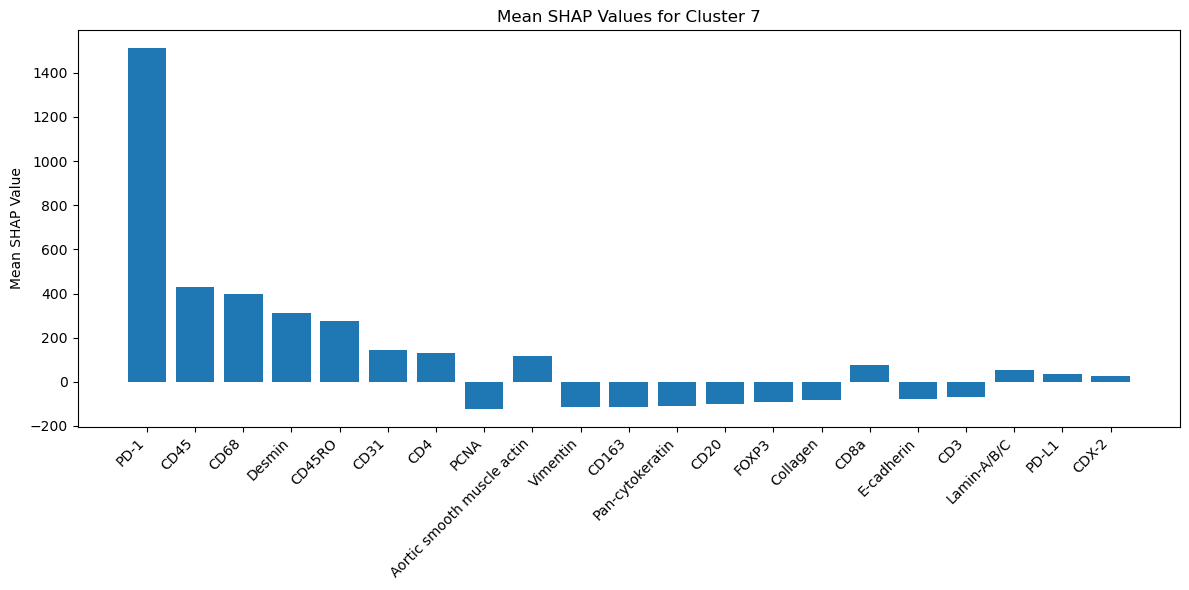

In [65]:
cluster_7 = greg_df[greg_df['kmeans'] == 7].index.tolist()
cluster_7_shap_values = [results_dict['greg']['shap_values'][i] for i in cluster_7]
np.array(cluster_7_shap_values).shape
# take mean across 0 and 2 axis
mean_values = np.mean(cluster_7_shap_values, axis=(0, 2))
absolute_values = np.abs(np.mean(cluster_7_shap_values, axis=0)).sum(axis=1)
# Plot mean values with corresponding feature names
potential_features
# plot shap values
# Plot in descending order of absolute values
sorted_indices = np.argsort(np.abs(mean_values))[::-1]
sorted_mean_values = mean_values[sorted_indices]
sorted_potential_features = np.array(potential_features)[sorted_indices]
plt.figure(figsize=(12, 6))
plt.bar(sorted_potential_features, sorted_mean_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean SHAP Value')
plt.title('Mean SHAP Values for Cluster 7')
plt.tight_layout()

In [66]:
exemplar_df

,CellID,DNA_6,ELANE,CD57,CD45,DNA_7,CD11B,SMA,CD16,DNA_8,...,Eccentricity,Solidity,Extent,Orientation,UMAP_X,UMAP_Y,kmeans,agcluster,EEMB_x,EEMB_y
0,1,17597.443478,1176.791304,160.782609,703.991304,5866.643478,377.400000,245.260870,331.278261,6816.017391,...,0.295521,0.966387,0.798611,-1.104797,336.372019,1910.968537,Kluster 7,Cluster 7,336.372019,1910.968537
1,2,18031.086957,1125.282609,176.934783,792.826087,11817.923913,910.304348,422.347826,646.923913,13424.717391,...,0.541562,0.948454,0.696970,-0.435290,1082.982972,2896.412217,Kluster 8,Cluster 3,1082.982972,2896.412217
2,3,8402.596774,1249.532258,156.951613,816.225806,5040.790323,1046.177419,487.854839,601.790323,5557.935484,...,0.496871,0.837838,0.563636,1.355995,583.642188,323.947450,Kluster 6,Cluster 8,583.642188,323.947450
3,4,22322.404412,1156.683824,187.330882,853.250000,13716.878676,816.955882,2187.911765,376.194853,15479.356618,...,0.805900,0.834356,0.537549,-0.709765,1797.930493,2785.830015,Kluster 4,Cluster 6,1797.930493,2785.830015
4,5,8101.017199,1570.628993,163.009828,318.027027,4959.896806,826.963145,361.771499,366.088452,5628.589681,...,0.678529,0.933486,0.707826,-0.719601,594.190207,272.817062,Kluster 6,Cluster 8,594.190207,272.817062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,11166,14693.016949,1224.372881,208.853107,1071.937853,8231.203390,865.022599,1187.045198,379.988701,10322.225989,...,0.839933,0.917098,0.702381,-1.390099,482.865243,1996.896298,Kluster 7,Cluster 7,482.865243,1996.896298
11166,11167,23067.893939,1217.439394,228.727273,1247.242424,13142.106061,775.621212,1038.151515,367.500000,12688.318182,...,0.606722,0.891892,0.660000,-0.387542,1628.840064,2833.308199,Kluster 4,Cluster 3,1628.840064,2833.308199
11167,11168,24690.942029,1173.768116,206.217391,973.942029,14485.637681,706.695652,1816.202899,353.681159,17806.826087,...,0.699592,0.920000,0.766667,0.774327,2169.361706,2407.385774,Kluster 1,Cluster 6,2169.361706,2407.385774
11168,11169,21059.903226,1159.645161,224.365591,1073.870968,12691.688172,745.096774,1143.000000,364.215054,15388.989247,...,0.467857,0.939394,0.845455,-1.296469,1598.257743,2926.824546,Kluster 4,Cluster 3,1598.257743,2926.824546


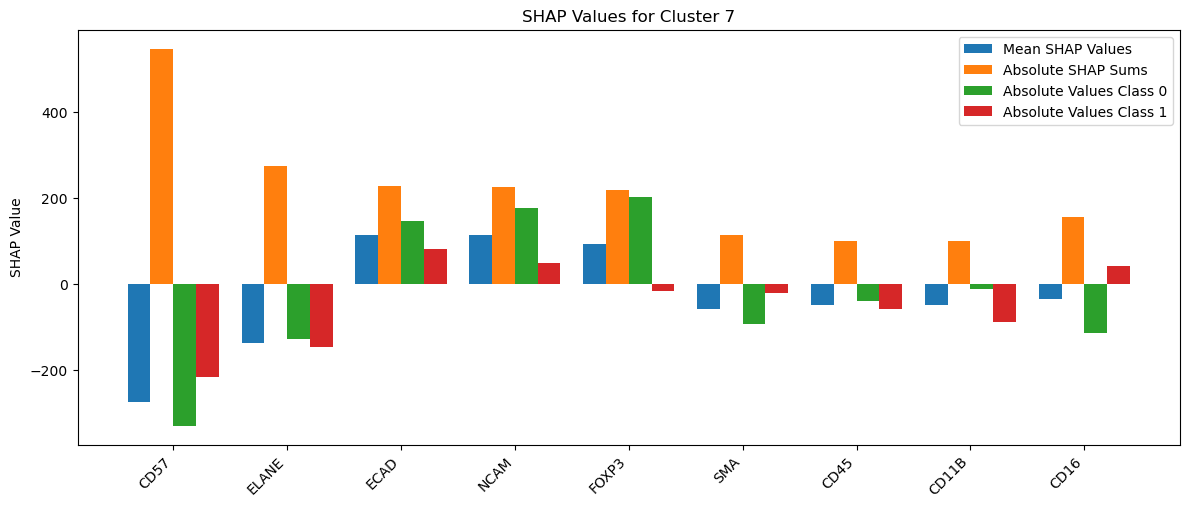

In [67]:
import numpy as np
import matplotlib.pyplot as plt

cluster_7 = exemplar_df[exemplar_df['kmeans'] == 'Kluster 4'].index.tolist()
cluster_7_shap_values = [results_dict['exemplar']['shap_values'][i] for i in cluster_7]

# Extract potential feature names
potential_features = get_potential_features(exemplar_df)

# Compute SHAP values
mean_values = np.mean(cluster_7_shap_values, axis=(0, 2))
values = np.mean(cluster_7_shap_values, axis=0)  # Shape (features, classes)
absolute_sums = np.sum(np.abs(values), axis=1)

# Sort values in descending order of absolute mean values
sorted_indices = np.argsort(np.abs(mean_values))[::-1]
sorted_potential_features = np.array(potential_features)[sorted_indices]  # Apply sorting

# Apply sorting to computed SHAP metrics
sorted_mean_values = mean_values[sorted_indices]
sorted_absolute_values = values[sorted_indices, :]  # Preserve both class columns
sorted_absolute_sums = absolute_sums[sorted_indices]

# Plot setup
plt.figure(figsize=(12, 6))
x = np.arange(len(sorted_potential_features))
width = 0.2  # Adjust width to space bars correctly

# Plot bars side-by-side
plt.bar(x - 1.5 * width, sorted_mean_values, width, label='Mean SHAP Values')
plt.bar(x - 0.5 * width, sorted_absolute_sums, width, label='Absolute SHAP Sums')
plt.bar(x + 0.5 * width, sorted_absolute_values[:, 0], width, label='Absolute Values Class 0')
plt.bar(x + 1.5 * width, sorted_absolute_values[:, 1], width, label='Absolute Values Class 1')

# Formatting
plt.xticks(x, sorted_potential_features, rotation=45, ha='right')  # Ensure proper feature labeling
plt.ylabel('SHAP Value')
plt.title('SHAP Values for Cluster 7')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Increase space at bottom for labels
plt.show()

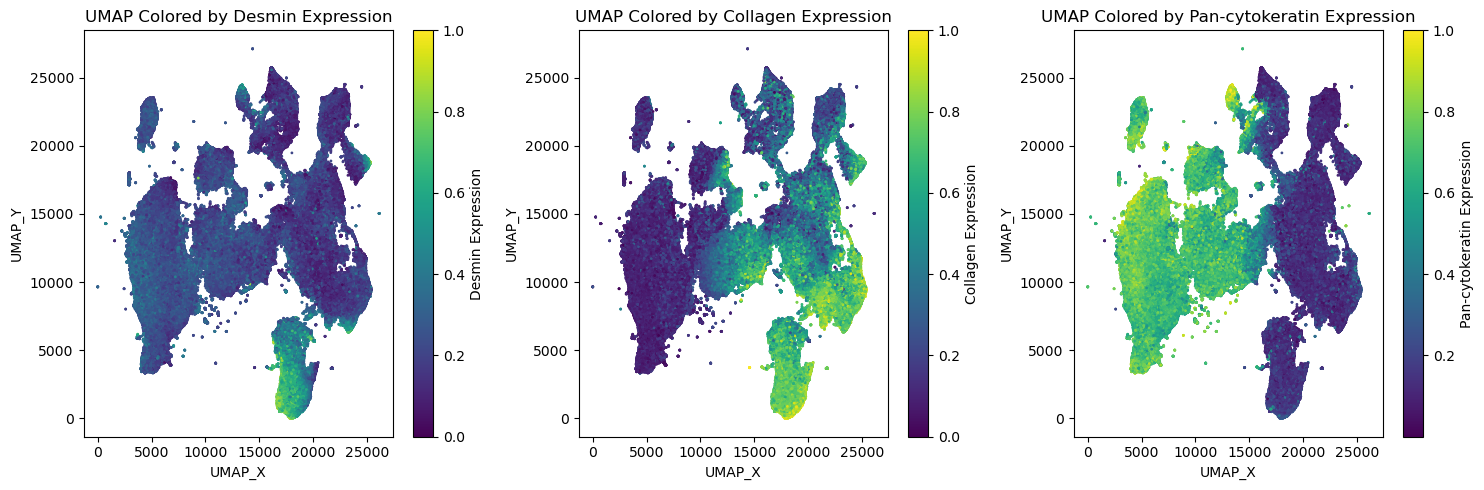

In [68]:
# Make two subplots, one with the clusters and one with the 'Desmin' column as the color
plt.figure(figsize=(15, 5))

# First subplot - UMAP with clusters


# Second subplot - UMAP with Desmin expression
plt.subplot(1, 3, 1)
scatter = plt.scatter(greg_df['UMAP_X'], greg_df['UMAP_Y'], c=greg_df['Desmin'], cmap='viridis', s=1)
plt.colorbar(scatter, label='Desmin Expression')
plt.xlabel('UMAP_X')
plt.ylabel('UMAP_Y')
plt.title('UMAP Colored by Desmin Expression')

# Second subplot - UMAP with Desmin expression
plt.subplot(1, 3, 2)
scatter = plt.scatter(greg_df['UMAP_X'], greg_df['UMAP_Y'], c=greg_df['Collagen'], cmap='viridis', s=1)
plt.colorbar(scatter, label='Collagen Expression')
plt.xlabel('UMAP_X')
plt.ylabel('UMAP_Y')
plt.title('UMAP Colored by Collagen Expression')


# Second subplot - UMAP with Desmin expression
plt.subplot(1, 3, 3)
scatter = plt.scatter(greg_df['UMAP_X'], greg_df['UMAP_Y'], c=greg_df['Pan-cytokeratin'], cmap='viridis', s=1)
plt.colorbar(scatter, label='Pan-cytokeratin Expression')
plt.xlabel('UMAP_X')
plt.ylabel('UMAP_Y')
plt.title('UMAP Colored by Pan-cytokeratin Expression')

plt.tight_layout()